In [10]:
import sys
import numpy as np
from tqdm import tqdm_notebook
import pickle
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init_common as x
import simulate_corona_multi as sf
import multiprocessing as mp
import helpers as hp

## setting
alpha_option_type = 3# alpha: 0=all, 1=high, 2=med, 3=low, 
x.R0_type = 0
out_filename_root,out_fig_root,out_stat_root=hp.setup_paths(x.R0_type)
out_filename_pct0 = out_filename_root+"/"+x.out_filename_pct0

if x.R0_type==0:    
    import init_spec_gamma as xx
    import simulate_corona_multi as sf
elif x.R0_type==1:
    import init_spec_gamma as xx
    import simulate_corona_senior_multi as sf 

# print(out_filename_raw0)

## initialize
np.random.seed(123)
pct_data=[]
raw_data=[]

alpha_min = 0.5
alpha_max = 1
alpha_step = (alpha_max-alpha_min)/3

def run_simulation(alpha_vec,fun):
    # ra = []
    # rb = []
    cores_cnt = mp.cpu_count()
    pool = mp.Pool(cores_cnt)
    tic = time.perf_counter()
    res = pool.map(fun,alpha_vec)
    toc = time.perf_counter()
    pool.close()
    dt_avg = (toc-tic)/x.N_simul
    # for k in np.arange(x.N_simul):
        #ra0,rb0 = res[k]
        #ra.append(ra0)
        #rb.append(rb0)
    return res,dt_avg 

def save_results(filename,data,stat=False):
    if stat:       
        pct_S_mean = hp.mean_list(data,'sus')
        pct_I_mean = hp.mean_list(data,'inf')
        pct_R_mean = hp.mean_list(data,'rec')
        pct_S_std = hp.std_list(data,'sus')
        pct_I_std = hp.std_list(data,'inf')
        pct_R_std = hp.std_list(data,'rec')
        data = pd.DataFrame(list(zip(pct_S_mean, pct_I_mean, pct_R_mean, pct_S_std,pct_I_std,pct_R_std)), 
                         columns = ['sus_mean','inf_mean','rec_mean','sus_std','inf_std','rec_std'])
    fid = open(filename+".pickle",'wb')
    pickle.dump(data,fid)
    fid.close()
    
opt_ok = True
if alpha_option_type == 0:
    alpha_val = np.arange(alpha_min,alpha_max+0.99*alpha_step,alpha_step)
    alpha_len = len(alpha_val)
    fnc_name = sf.simul
    file_ext = "_all"
elif alpha_option_type == 1: # high alpha
    alpha_val = x.public_trans_high
    fnc_name = sf.simul
    file_ext = "_high"
elif alpha_option_type == 2: # medium alpha
    alpha_val = x.public_trans_mid
    fnc_name = sf.simul
    file_ext = "_med"
elif alpha_option_type == 3: # low alpha
    alpha_val = x.public_trans_low
    fnc_name = sf.simul
    file_ext = "_low"
else:
    print("Incorrect option")
    opt_ok = False

print("Option type: "+str(alpha_option_type))
print("R0:"+str(x.R0))
print("alpha:"+str(alpha_val))
print("beta:"+str(xx.beta_mean))

if opt_ok:
    if alpha_option_type>0:
        alpha_vec = np.full(x.N_simul,alpha_val)
    else:
        n = round(mp.cpu_count()/alpha_len)
        alpha_vec = np.repeat(alpha_val,n)
        

    ## run all simulations and 
    print("Running simulation ... ",end="",flush=True)
    pct_data,tpi=run_simulation(alpha_vec,fnc_name)
    print("Finished")
    print("Time per iteration (sec.): "+str(tpi))

    ## save results
    print("Saving results ...",end="",flush=True)
    save_results(out_filename_pct0+file_ext,pct_data,stat=False)
    print("Finished")    
    

Option type: 3
R0:2.2
alpha:0.6
beta:0.33835302651118193
Running simulation ... Finished
Time per iteration (sec.): 3.457252020796872
Saving results ...Finished


Basic Statistics: number of infected people
Peak, mean value:  12159.0  day:  199
Peak, mean+2*std value :  18840.0  day:  190
Peak, mean-2*std value :  5742.0  day:  190


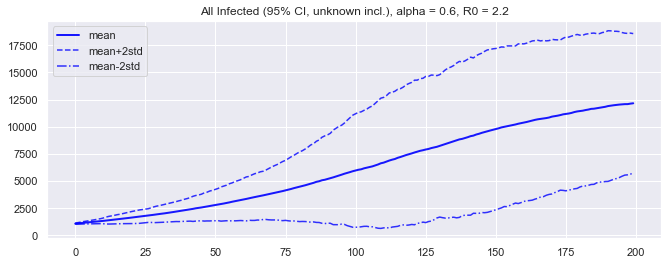

In [11]:
## statistics, plotting
if alpha_option_type==0:
    n = round(mp.cpu_count()/alpha_len)
    for ia in range(alpha_len):
        y = pct_data[ia*n:(ia+1)*n]
        alp = int(alpha_val[i]*100)
        save_results(x.out_filename_pct0+"_alpha_"+str(alp),y,stat=True)
else:
    save_results(x.out_filename_pct0+file_ext+"_stat",pct_data,stat=True)
    pct_I_mean = hp.mean_list(pct_data,'inf')
    pct_I_std = hp.std_list(pct_data,'inf')
    print("Basic Statistics: number of infected people")
    m = np.round(x.N_popul_size*np.array(pct_I_mean))
    s = np.round(x.N_popul_size*np.array(pct_I_std))
    m1=m+3*s
    m2=m-3*s
    xval=np.arange(0,x.N_per)
    print('Peak, mean value: ',np.round(m.max()),' day: ',m.argmax())
    print('Peak, mean+2*std value : ',np.round(m1.max()),' day: ',m1.argmax())
    print('Peak, mean-2*std value : ',np.round(m2.max()),' day: ',m1.argmax())    
    plt.plot(xval,m,color='blue',linewidth=2,alpha=.9)
    plt.plot(xval,m1,color='blue',linestyle='--',alpha=.8)
    plt.plot(xval,m2,color='blue',linestyle='-.',alpha=.8)
    plt.legend(['mean', 'mean+2std', 'mean-2std'])
    plt.title("All Infected (95% CI, unknown incl.), alpha = "+str(np.round(alpha_val,3))+ ", R0 = "+ str(np.round(x.R0,2)))